In [3]:
#!pip install tensorflow

In [2]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [4]:
import numpy as np
import pypianoroll as ppr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense,Activation
from tensorflow.keras.callbacks import LambdaCallback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pypianoroll import Track
import matplotlib.pyplot as plt
import pickle

In [5]:
pickle_file_path = 'dataset.pickle'
# Load the pickle file
with open(pickle_file_path, 'rb') as file:
    dataset = pickle.load(file)

In [6]:
drums_tracks=dataset["Drums"]
drums_tracks

[StandardTrack(name='Drums', program=0, is_drum=True, pianoroll=array(shape=(11136, 128), dtype=uint8)),
 StandardTrack(name='Drums', program=0, is_drum=True, pianoroll=array(shape=(12096, 128), dtype=uint8)),
 StandardTrack(name='Drums', program=0, is_drum=True, pianoroll=array(shape=(10872, 128), dtype=uint8)),
 StandardTrack(name='Drums', program=0, is_drum=True, pianoroll=array(shape=(15552, 128), dtype=uint8)),
 StandardTrack(name='Drums', program=0, is_drum=True, pianoroll=array(shape=(1560, 128), dtype=uint8)),
 StandardTrack(name='Drums', program=0, is_drum=True, pianoroll=array(shape=(11328, 128), dtype=uint8)),
 StandardTrack(name='Drums', program=0, is_drum=True, pianoroll=array(shape=(14784, 128), dtype=uint8)),
 StandardTrack(name='Drums', program=0, is_drum=True, pianoroll=array(shape=(8376, 128), dtype=uint8)),
 StandardTrack(name='Drums', program=0, is_drum=True, pianoroll=array(shape=(16896, 128), dtype=uint8)),
 StandardTrack(name='Drums', program=0, is_drum=True, pia

In [7]:
def remove_silence(pianoroll):
    """
    Remove silent time steps (all-zero pitches) from a pianoroll.

    Parameters:
    - pianoroll (np.ndarray): Pianoroll data with shape (num_time_steps, num_pitches).

    Returns:
    - np.ndarray: Pianoroll data with silent time steps removed.
    """
    # Check if each time step is silent (all-zero pitches)
    non_silent_mask = np.any(pianoroll > 0, axis=1)

    # Extract non-silent time steps
    return pianoroll[non_silent_mask]

In [8]:
# Remove silence from each track
filtered_tracks = []
for track in drums_tracks:
    filtered_pianoroll = remove_silence(track.pianoroll)
    filtered_track = ppr.StandardTrack(name=track.name, program=track.program, is_drum=track.is_drum, pianoroll=filtered_pianoroll)
    filtered_tracks.append(filtered_track)

In [9]:
filtered_tracks

[StandardTrack(name='Drums', program=0, is_drum=True, pianoroll=array(shape=(1266, 128), dtype=uint8)),
 StandardTrack(name='Drums', program=0, is_drum=True, pianoroll=array(shape=(881, 128), dtype=uint8)),
 StandardTrack(name='Drums', program=0, is_drum=True, pianoroll=array(shape=(749, 128), dtype=uint8)),
 StandardTrack(name='Drums', program=0, is_drum=True, pianoroll=array(shape=(553, 128), dtype=uint8)),
 StandardTrack(name='Drums', program=0, is_drum=True, pianoroll=array(shape=(74, 128), dtype=uint8)),
 StandardTrack(name='Drums', program=0, is_drum=True, pianoroll=array(shape=(1245, 128), dtype=uint8)),
 StandardTrack(name='Drums', program=0, is_drum=True, pianoroll=array(shape=(1409, 128), dtype=uint8)),
 StandardTrack(name='Drums', program=0, is_drum=True, pianoroll=array(shape=(1032, 128), dtype=uint8)),
 StandardTrack(name='Drums', program=0, is_drum=True, pianoroll=array(shape=(1649, 128), dtype=uint8)),
 StandardTrack(name='Drums', program=0, is_drum=True, pianoroll=array

In [10]:
pianoroll_arrays = [track.pianoroll for track in filtered_tracks]

In [11]:
pianoroll_data = np.concatenate(pianoroll_arrays, axis=0)

In [12]:
pianoroll_data.shape

(40259, 128)

In [20]:
timesteps = 10  # Number of timesteps in each sequence

scaler = MinMaxScaler(feature_range=(0, 1))
pianoroll_data_scaled = scaler.fit_transform(pianoroll_data)

# Prepare sequences and corresponding targets
X = []
y = []

for i in range(len(pianoroll_data_scaled) - timesteps):
    X.append(pianoroll_data_scaled[i:i + timesteps])
    y.append(pianoroll_data_scaled[i + timesteps])

X = np.array(X)
y = np.array(y)

print(X.shape)  # Should be (num_samples, timesteps, 128)
print(y.shape)  # Should be (num_samples, 128)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)  # Training data shape
print(X_val.shape)    # Validation data shape

(40249, 10, 128)
(40249, 128)
(32199, 10, 128)
(8050, 10, 128)


#### Simple Model

In [21]:
model = Sequential()
model.add(LSTM(128, input_shape=(timesteps, 128), return_sequences=True))
model.add(LSTM(128))
model.add(Dense(128))  # No activation function since we're doing regression
model.add(Activation('softplus'))  # Activation function to ensure non-negative output

model.compile(optimizer='adam', loss='mean_squared_error')


C:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### More Complicated model

In [22]:
# model = Sequential()
# model.add(LSTM(128, input_shape=(timesteps, 128), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(128))
# model.add(Dense(128))  

# model.compile(optimizer='adam', loss='mean_squared_error')


#### Training

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 279,680 (1.07 MB)

 Trainable params: 279,680 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - loss: 0.0579 - val_loss: 0.0062
Epoch 2/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - loss: 0.0062 - val_loss: 0.0062
Epoch 3/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 4/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 5/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 6/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 7/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 8/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 9/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 10/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.0033 - val_loss: 0.0032


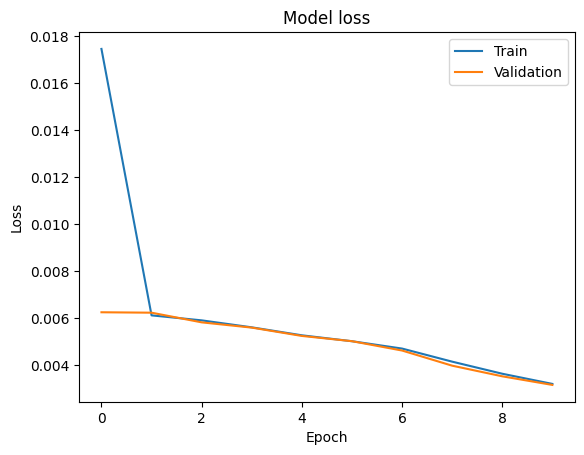

In [23]:

model.summary()

# Train the model with validation data
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [27]:
# Make predictions on the validation set
y_pred = model.predict(X_val)

# Compare the prediction with the actual value
print("Predicted:", y_pred[2])
print("Actual:", y_val[2])


252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Predicted: [8.3268818e-04 1.5087161e-03 9.3094690e-04 6.5347686e-04 7.2891469e-04
 9.2262012e-04 1.3087161e-03 1.9072115e-03 1.1669748e-03 7.6879049e-04
 8.1018894e-04 6.1072939e-04 1.0005516e-03 1.1157891e-03 1.0583914e-03
 2.1048149e-03 1.7061356e-03 5.6464359e-04 9.4142178e-04 6.0456427e-04
 1.0511422e-03 7.2122965e-04 2.5773691e-03 1.2922258e-03 2.2438297e-03
 7.3759299e-04 6.3841458e-04 1.1238286e-03 2.2029472e-03 9.1729499e-04
 1.0848441e-03 4.3193178e-04 9.1839605e-04 4.8687062e-03 8.0313289e-04
 8.3137013e-02 4.1555697e-03 2.7513154e-02 8.0414154e-02 7.4454932e-04
 2.1269000e-03 4.4906703e-03 4.7271895e-01 2.4812089e-03 4.2036166e-03
 2.6000671e-03 1.0010797e-02 2.7815213e-03 1.2925658e-03 7.9018772e-03
 1.7135742e-03 4.0725354e-04 1.3585386e-03 3.4715382e-03 1.3732610e-02
 1.4848921e-03 8.2342047e-03 9.0982142e-04 9.9540572e-04 7.8831328e-04
 8.3573852e-03 2.7623475e-03 7.3844858e-04 3.4002117e-03 8.8271918e-04
 5.2474975e-04 2.5935178e

In [29]:
for i in range(len(y_val[5])):
    print(y_val[5][i],y_pred[5][i])

0.0 0.0029487952
0.0 0.002288112
0.0 0.0023125955
0.0 0.003133116
0.0 0.0015405891
0.0 0.0025379288
0.0 0.0038971596
0.0 0.003647851
0.0 0.0018927403
0.0 0.0024311976
0.0 0.0034215264
0.0 0.0022694513
0.0 0.0028757975
0.0 0.004542439
0.0 0.0013730522
0.0 0.0028326523
0.0 0.006047978
0.0 0.0019150164
0.0 0.0029953108
0.0 0.0016281821
0.0 0.0015829533
0.0 0.0021121535
0.0 0.0044998066
0.0 0.0027050565
0.0 0.00565019
0.0 0.0018519786
0.0 0.002868429
0.0 0.0035217274
0.0 0.0023494463
0.0 0.0033573029
0.0 0.0022912587
0.0 0.012619063
0.0 0.0050433367
0.0 0.007863404
0.0 0.0026647106
0.0 0.004199128
0.0 0.05683247
0.0 0.0069062477
0.0 0.02314302
0.0 0.025355319
0.0 0.0076089418
0.0 0.0339542
0.0 0.07713777
0.0 0.0040220376
0.0 0.054090418
0.0 0.015823325
0.0 0.042326376
0.0 0.004379806
0.0 0.020611128
0.0 0.00968145
0.0 0.010268245
0.0 0.009049585
0.0 0.0024212839
0.0 0.02824516
0.0 0.014452617
0.0 0.003618927
0.0 0.02663941
0.0 0.0027671126
0.0 0.004432325
0.0 0.0066567203
0.0 0.023297757
0

#### Generate 300 sequential samples

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

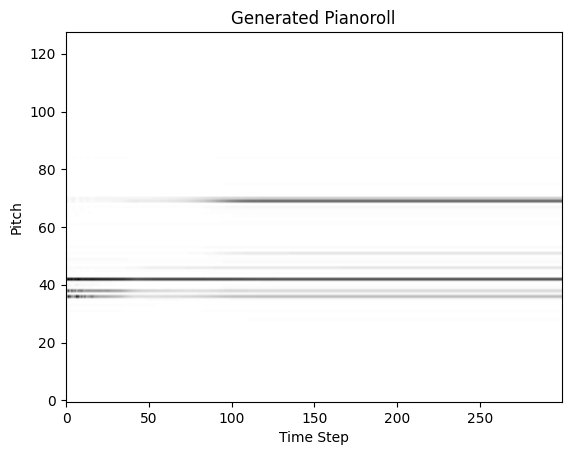

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming pianoroll_data is your original data and the model is already trained

# Scale data to range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
pianoroll_data_scaled = scaler.fit_transform(pianoroll_data)

timesteps = 10  # Number of timesteps in each sequence

# Generate new pianoroll data
initial_sequence = pianoroll_data_scaled[3000:3000+timesteps]  # Take the first 10 time steps as the initial input
generated_sequence = initial_sequence.tolist()

num_generated_steps = 300

for _ in range(num_generated_steps):
    input_sequence = np.array([generated_sequence[-timesteps:]])  # Use the last 10 steps as input
    new_step = model.predict(input_sequence)
    generated_sequence.append(new_step[0])  # Append the new step to the sequence

# Convert the generated sequence back to the original scale
generated_sequence = np.array(generated_sequence)
generated_sequence_rescaled = scaler.inverse_transform(generated_sequence)
generated_sequence_rounded = np.round(generated_sequence_rescaled)

# Clip the values to ensure they are within the range [0, 127]
generated_sequence_clipped = np.clip(generated_sequence_rounded, 0, 127).astype(int)

# Extract the generated steps (excluding the initial sequence)
generated_pianoroll = generated_sequence_clipped[timesteps:]

# Plot the generated pianoroll
plt.imshow(generated_pianoroll.T, aspect='auto', cmap='gray_r', origin='lower')
plt.title('Generated Pianoroll')
plt.xlabel('Time Step')
plt.ylabel('Pitch')
plt.show()
